In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU,Attention
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
import warnings
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Done


In [2]:
Emotions = pd.read_csv('/kaggle/input/speech-emotion/emotion.csv')

In [3]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [4]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(46728, 2377)

In [5]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data Prepare

In [6]:
Y=Emotions['Emotions']
X= Emotions.drop('Emotions',axis= 1)

In [7]:
X.shape

(46728, 2376)

In [8]:
Y.shape

(46728,)

In [9]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [10]:
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [11]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=35,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382, 7), (9346, 2376), (9346, 7))

In [12]:
#reshape for lstm
X_train = x_train.to_numpy().reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.to_numpy().reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [13]:
# scale data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382, 7), (9346, 2376), (9346, 7))

In [14]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [15]:
model_checkpoint = ModelCheckpoint('best_model_local_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.5,min_lr=0.00001)

LSTM Model

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Lambda
from tensorflow.keras.models import Model

# Define the input shape
input_seq = Input(shape=(x_train.shape[1], 1))

# Define your LSTM layers with return_sequences=True
lstm1 = LSTM(512, return_sequences=True)(input_seq)
dropout1 = Dropout(0.3)(lstm1)
dense1 = Dense(256, activation='relu')(dropout1)
lstm2 = LSTM(256, return_sequences=True)(dense1)
dropout2 = Dropout(0.2)(lstm2)
dense2 = Dense(128, activation='relu')(dropout2)
lstm3 = LSTM(128, return_sequences=True)(dense2)
dropout3 = Dropout(0.3)(lstm3)

# Define a custom Attention layer
def attention_layer(inputs):
    return tf.keras.layers.Attention()([inputs, inputs])

# Apply the custom attention layer
attention_output = Lambda(attention_layer)(lstm3)

# Add a final LSTM layer
lstm_final = LSTM(128)(attention_output)

# Add the output layer
output = Dense(7, activation='softmax')(lstm_final)

# Create the model
model_with_attention = Model(inputs=input_seq, outputs=output)

# Compile the model
model_with_attention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_with_attention.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2376, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, 2376, 512)         1052672   
                                                                 
 dropout (Dropout)           (None, 2376, 512)         0         
                                                                 
 dense (Dense)               (None, 2376, 256)         131328    
                                                                 
 lstm_1 (LSTM)               (None, 2376, 256)         525312    
                                                                 
 dropout_1 (Dropout)         (None, 2376, 256)         0         
                                                                 
 dense_1 (Dense)             (None, 2376, 128)         32896 

In [24]:
 hist_attention=model_with_attention.fit(X_train, y_train,
            epochs=50,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)

In [ ]:
print("Accuracy of our model on test data : " , model_with_attention.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model_with_attention.predict(x_test)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

# CNN model


In [18]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((37382, 2376, 1), (37382, 7), (9346, 2376, 1), (9346, 7))

In [19]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (Batch  (None, 2376, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                        

In [20]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=128,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
293/293 [==============================] - 108s 331ms/step - loss: 1.3764 - accuracy: 0.4793 - val_loss: 1.9171 - val_accuracy: 0.2425 - lr: 0.0010
Epoch 2/50
293/293 [==============================] - 96s 328ms/step - loss: 1.0720 - accuracy: 0.5836 - val_loss: 1.4054 - val_accuracy: 0.4679 - lr: 0.0010
Epoch 3/50
293/293 [==============================] - 96s 328ms/step - loss: 0.9524 - accuracy: 0.6321 - val_loss: 0.9697 - val_accuracy: 0.6225 - lr: 0.0010
Epoch 4/50
293/293 [==============================] - 96s 327ms/step - loss: 0.8436 - accuracy: 0.6787 - val_loss: 1.1136 - val_accuracy: 0.5852 - lr: 0.0010
Epoch 5/50
293/293 [==============================] - 96s 327ms/step - loss: 0.8491 - accuracy: 0.6736 - val_loss: 0.9856 - val_accuracy: 0.6160 - lr: 0.0010
Epoch 6/50
293/293 [==============================] - 96s 328ms/step - loss: 0.7252 - accuracy: 0.7276 - val_loss: 0.7982 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 7/50
293/293 [==============================]

293/293 [==============================] - 7s 23ms/step - loss: 0.2020 - accuracy: 0.9471
Accuracy of our model on test data :  94.71431374549866 %


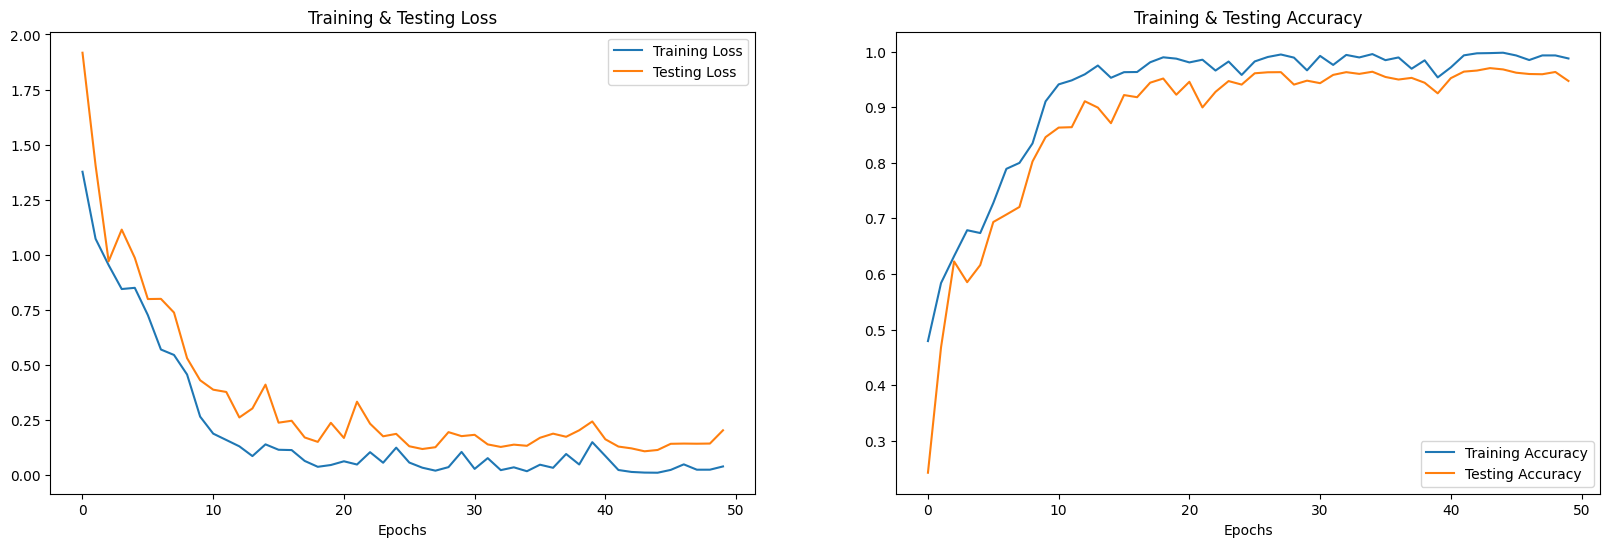

In [21]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [22]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

293/293 [==============================] - 6s 21ms/step


,Predicted Labels,Actual Labels
0,fear,fear
1,neutral,neutral
2,surprise,surprise
3,sad,sad
4,neutral,neutral
5,happy,happy
6,fear,fear
7,disgust,disgust
8,surprise,surprise
9,angry,angry
